In [1]:
import pyemma
import mdtraj as md

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

!pip install mdshare
import mdshare
import pyemma
# for visualization of molecular structures:
!pip install nglview
import nglview
import mdtraj
from threading import Timer
from nglview.player import TrajectoryPlayer
pyemma.__version__

'2.5.7'

In [2]:
%pylab inline
matplotlib.rcParams.update({'font.size': 14})

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
# Switch progress bars off, because this notebook would generate a lot of progress bars
#pyemma.config.show_progress_bars = 'False'

In [5]:
#define helper function 1
def remove_constant(X, threshold=0.001):
    if isinstance(X, np.ndarray):
        X = [X]
    Ds = [np.max(x, axis=0) - np.min(x, axis=0) for x in X]
    D = np.min(np.array(Ds), axis=0)
    Ivar = np.where(D > 0.001)[0]
    Y = [x[:, Ivar] for x in X]
    if len(Y) == 1:
        Y = Y[0]
    return Y

In [6]:
#define helper function 2
def project_and_cluster(trajfiles, featurizer, sparsify=False, tica=True, lag=100, scale=True, var_cutoff=0.95, ncluster=100):
    """
    Returns
    -------
    trans_obj, Y, clustering

    """
    X = coor.load(trajfiles, featurizer)
    if sparsify:
        X = remove_constant(X)
    if tica:
        trans_obj = coor.tica(X, lag=lag, var_cutoff=var_cutoff)
    else:
        trans_obj = coor.pca(X, dim=-1, var_cutoff=var_cutoff)
    Y = trans_obj.get_output()
    if scale:
        for y in Y:
            y *= trans_obj.eigenvalues[:trans_obj.dimension()]
    cl_obj = coor.cluster_kmeans(Y, k=ncluster, max_iter=3, fixed_seed=True)
    return trans_obj, Y, cl_obj

In [7]:
#define helper function 3
def eval_transformer(trans_obj):
    # Effective dimension (Really? If we just underestimate the Eigenvalues this value also shrinks...))
    print('Evaluating transformer: ', str(trans_obj.__class__))
    print('effective dimension', np.sum(1.0 - trans_obj.cumvar))
    print('eigenvalues', trans_obj.eigenvalues[:5])
    print('partial eigensum', np.sum(trans_obj.eigenvalues[:10]))
    print('total variance', np.sum(trans_obj.eigenvalues ** 2))
    print()

In [8]:
#define helper function 4
def plot_map(Y, sx=None, sy=None, tickspacing1=1.0, tickspacing2=1.0, timestep=1.0, timeunit='ns'):
    if not isinstance(Y, np.ndarray):
        Y = Y[0]
    if sx is None:
        sx = -np.sign(Y[0,0])
    if sy is None:
        sy = -np.sign(Y[0,1])
    Y1 = sx*Y[:, 0]
    min1 = np.min(Y1)
    max1 = np.max(Y1)
    Y2 = sy*Y[:, 1]
    min2 = np.min(Y2)
    max2 = np.max(Y2)
    # figure
    figure(figsize=(16,4))
    # trajectories
    subplot2grid((2,2), (0,0))
    plot(timestep*np.arange(len(Y1)), Y1)
    xlim(0, timestep*len(Y1))
    yticks(np.arange(int(min1), int(max1)+1, tickspacing1))
    ylabel('component 1')
    subplot2grid((2,2), (1,0))
    plot(timestep*np.arange(len(Y2)), Y2)
    xlim(0, timestep*len(Y2))
    ylabel('component 2')
    yticks(np.arange(int(min2), int(max2)+1, tickspacing2))
    xlabel('time / ' + timeunit)
    # histogram data
    subplot2grid((2,2), (0,1), rowspan=2)
    z,x,y = np.histogram2d(Y1, Y2, bins=50)
    z += 0.1
    # compute free energies
    F = -np.log(z)
    # contour plot
    extent = [x[0], x[-1], y[0], y[-1]]
    xticks(np.arange(int(min1), int(max1)+1, tickspacing1))
    yticks(np.arange(int(min2), int(max2)+1, tickspacing2))
    contourf(F.T, 50, cmap=plt.cm.nipy_spectral, extent=extent)
    xlabel('component 1')
    ylabel('component 2')

In [22]:
files = (['915_rep1.xtc'] + ['916_rep1.xtc'] + ['917_rep1.xtc'] + ['all_ba4.xtc.xtc'])

pdb = 'all_ba4.xtc.pdb'

In [23]:
feat = coor.featurizer(pdb) 

#feat = coor.featurizer(splitted_line)

#numpy.load(file, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
#df = np.load('C:\\Users\\azamr\\MMS_PXR_Ant\\virt_Al_4us_r1.pdb',mmap_mode=None, allow_pickle=True, fix_imports=True, encoding='ASCII') 
#df = md.load('C:\\Users\\azamr\\MMS_PXR_Ant\\virt_Al_4us_r1.pdb')
#print (df)

with open('915_rep1.pdb') as pdbfile:
    for line in pdbfile:
        if line[:4] == 'ATOM' or line[:6] == "HETATM":
            #print (line)
            splitted_line = [ line[22:26]]# line[30:38], line[38:46],line[46:54], line [70:78]]
            for i in splitted_line:
                #print (i)
            #print (splitted_line)
 


# feat = coor.featurizer(pdb) 
# #tähän feat
# #feat.add_backbone_torsions()
indeksit=feat.select_Ca()
selected_index=indeksit[np.array(i for i in splitted_line)]
print(selected_index)                               
                        
#feat.add_distances(selected_index)


# print(feat.describe())

# data = pyemma.coordinates.load(files, features=feat)

# print('type of data:', type(data))
# print('lengths:', len(data))
# print('shape of elements:', data[0].shape)



IndentationError: expected an indented block (<ipython-input-23-2dc3976816c0>, line 24)

In [24]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
#feat.add_distances_ca(periodic=False)
print(feat.describe())
# pyemma.coordinates.load() to load data into memory, and - pyemma.coordinates.source() to create a streamed feature reader in case the data does not fit into memory.
data = pyemma.coordinates.load(files, features=feat)
# to define a selection of features we want to extract, 
print('type of data:', type(data))
print('lengths:', len(data))
print('shape of elements:', data[0].shape)

['PHI 0 PHE 8', 'PSI 0 VAL 7', 'PHI 0 THR 9', 'PSI 0 PHE 8', 'PHI 0 THR 10', 'PSI 0 THR 9', 'PHI 0 VAL 11', 'PSI 0 THR 10', 'PHI 0 ASP 12', 'PSI 0 VAL 11', 'PHI 0 ASN 13', 'PSI 0 ASP 12', 'PHI 0 ILE 14', 'PSI 0 ASN 13', 'PHI 0 ASN 15', 'PSI 0 ILE 14', 'PHI 0 LEU 16', 'PSI 0 ASN 15', 'PHI 0 HIS 17', 'PSI 0 LEU 16', 'PHI 0 THR 18', 'PSI 0 HIS 17', 'PHI 0 GLN 19', 'PSI 0 THR 18', 'PHI 0 VAL 20', 'PSI 0 GLN 19', 'PHI 0 VAL 21', 'PSI 0 VAL 20', 'PHI 0 ASP 22', 'PSI 0 VAL 21', 'PHI 0 MET 23', 'PSI 0 ASP 22', 'PHI 0 SER 24', 'PSI 0 MET 23', 'PHI 0 MET 25', 'PSI 0 SER 24', 'PHI 0 THR 26', 'PSI 0 MET 25', 'PHI 0 TYR 27', 'PSI 0 THR 26', 'PHI 0 GLY 28', 'PSI 0 TYR 27', 'PHI 0 GLN 29', 'PSI 0 GLY 28', 'PHI 0 GLN 30', 'PSI 0 GLN 29', 'PHI 0 PHE 31', 'PSI 0 GLN 30', 'PHI 0 GLY 32', 'PSI 0 PHE 31', 'PHI 0 PRO 33', 'PSI 0 GLY 32', 'PHI 0 THR 34', 'PSI 0 PRO 33', 'PHI 0 TYR 35', 'PSI 0 THR 34', 'PHI 0 LEU 36', 'PSI 0 TYR 35', 'PHI 0 ASP 37', 'PSI 0 LEU 36', 'PHI 0 GLY 38', 'PSI 0 ASP 37', 'PHI 0 ALA 3

Obtaining file info:   0%|          | 0/4 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/4 [00:00<?, ?it/s]

type of data: <class 'list'>
lengths: 4
shape of elements: (10025, 608)


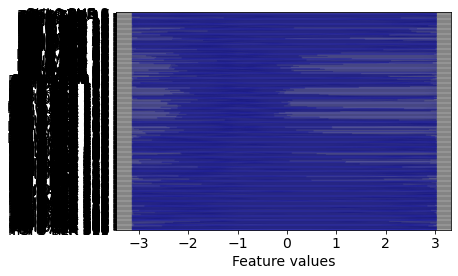

In [25]:
data_concatenated = np.concatenate(data)
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feat, ignore_dim_warning=True);

#RuntimeError: This function is only useful for less than 50 dimensions. Turn-off this warning at your own risk with ignore_dim_warning=True.

In [26]:
score_pair_heavy_atom_dists = pyemma.coordinates.vamp(data[:-1], dim=3).score(
    test_data=data[-1],
    score_method='VAMP2')
print('VAMP2-score: {:.2f}'.format(score_pair_heavy_atom_dists))
#to score the quality of the features

calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

VAMP2-score: 1.92


In [27]:
score_phi_psi = pyemma.coordinates.vamp(data[:-1], dim=2).score(
        test_data=data[-1],
        score_method='VAMP2')
print('VAMP2-score backbone torsions: {:.2f}'.format(score_phi_psi))
##The score of 1.5 means that we have the constant of 1 plus a total contribution of 0.5 from the other dynamic processes.

calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

VAMP2-score backbone torsions: 1.74


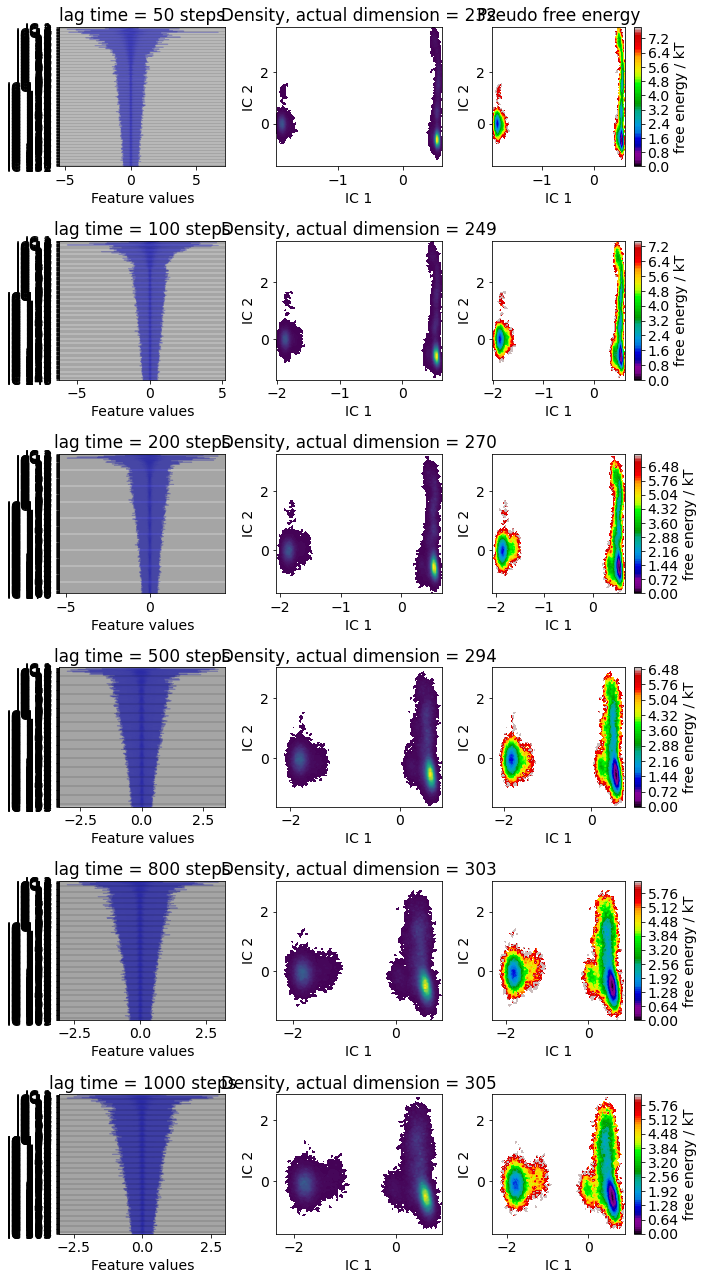

In [33]:
#to show the distributions of all loaded features
#the free energy surface is defined by the negative logarithm of the probability computed from the histogram counts

lags = [50, 100, 200, 500, 800, 1000]


fig, axes = plt.subplots(6, 3, figsize=(10, 18))
for i, lag in enumerate(lags):
    tica = pyemma.coordinates.tica(data_concatenated, lag=lag)
    tica_concatenated = np.concatenate(tica.get_output())
    pyemma.plots.plot_feature_histograms(
        tica_concatenated,
        ['IC {}'.format(i + 1) for i in range(tica.dimension())],
        ax=axes[i, 0], ignore_dim_warning=True)
    axes[i, 0].set_title('lag time = {} steps'.format(lag))
    axes[i, 1].set_title(
        'Density, actual dimension = {}'.format(tica.dimension()))
    pyemma.plots.plot_density(
        *tica_concatenated[:, :2].T, ax=axes[i, 1], cbar=False)
    pyemma.plots.plot_free_energy(
        *tica_concatenated[:, :2].T, ax=axes[i, 2], legacy=False)
for ax in axes[:, 1:].flat:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
axes[0, 2].set_title('Pseudo free energy')
fig.tight_layout()

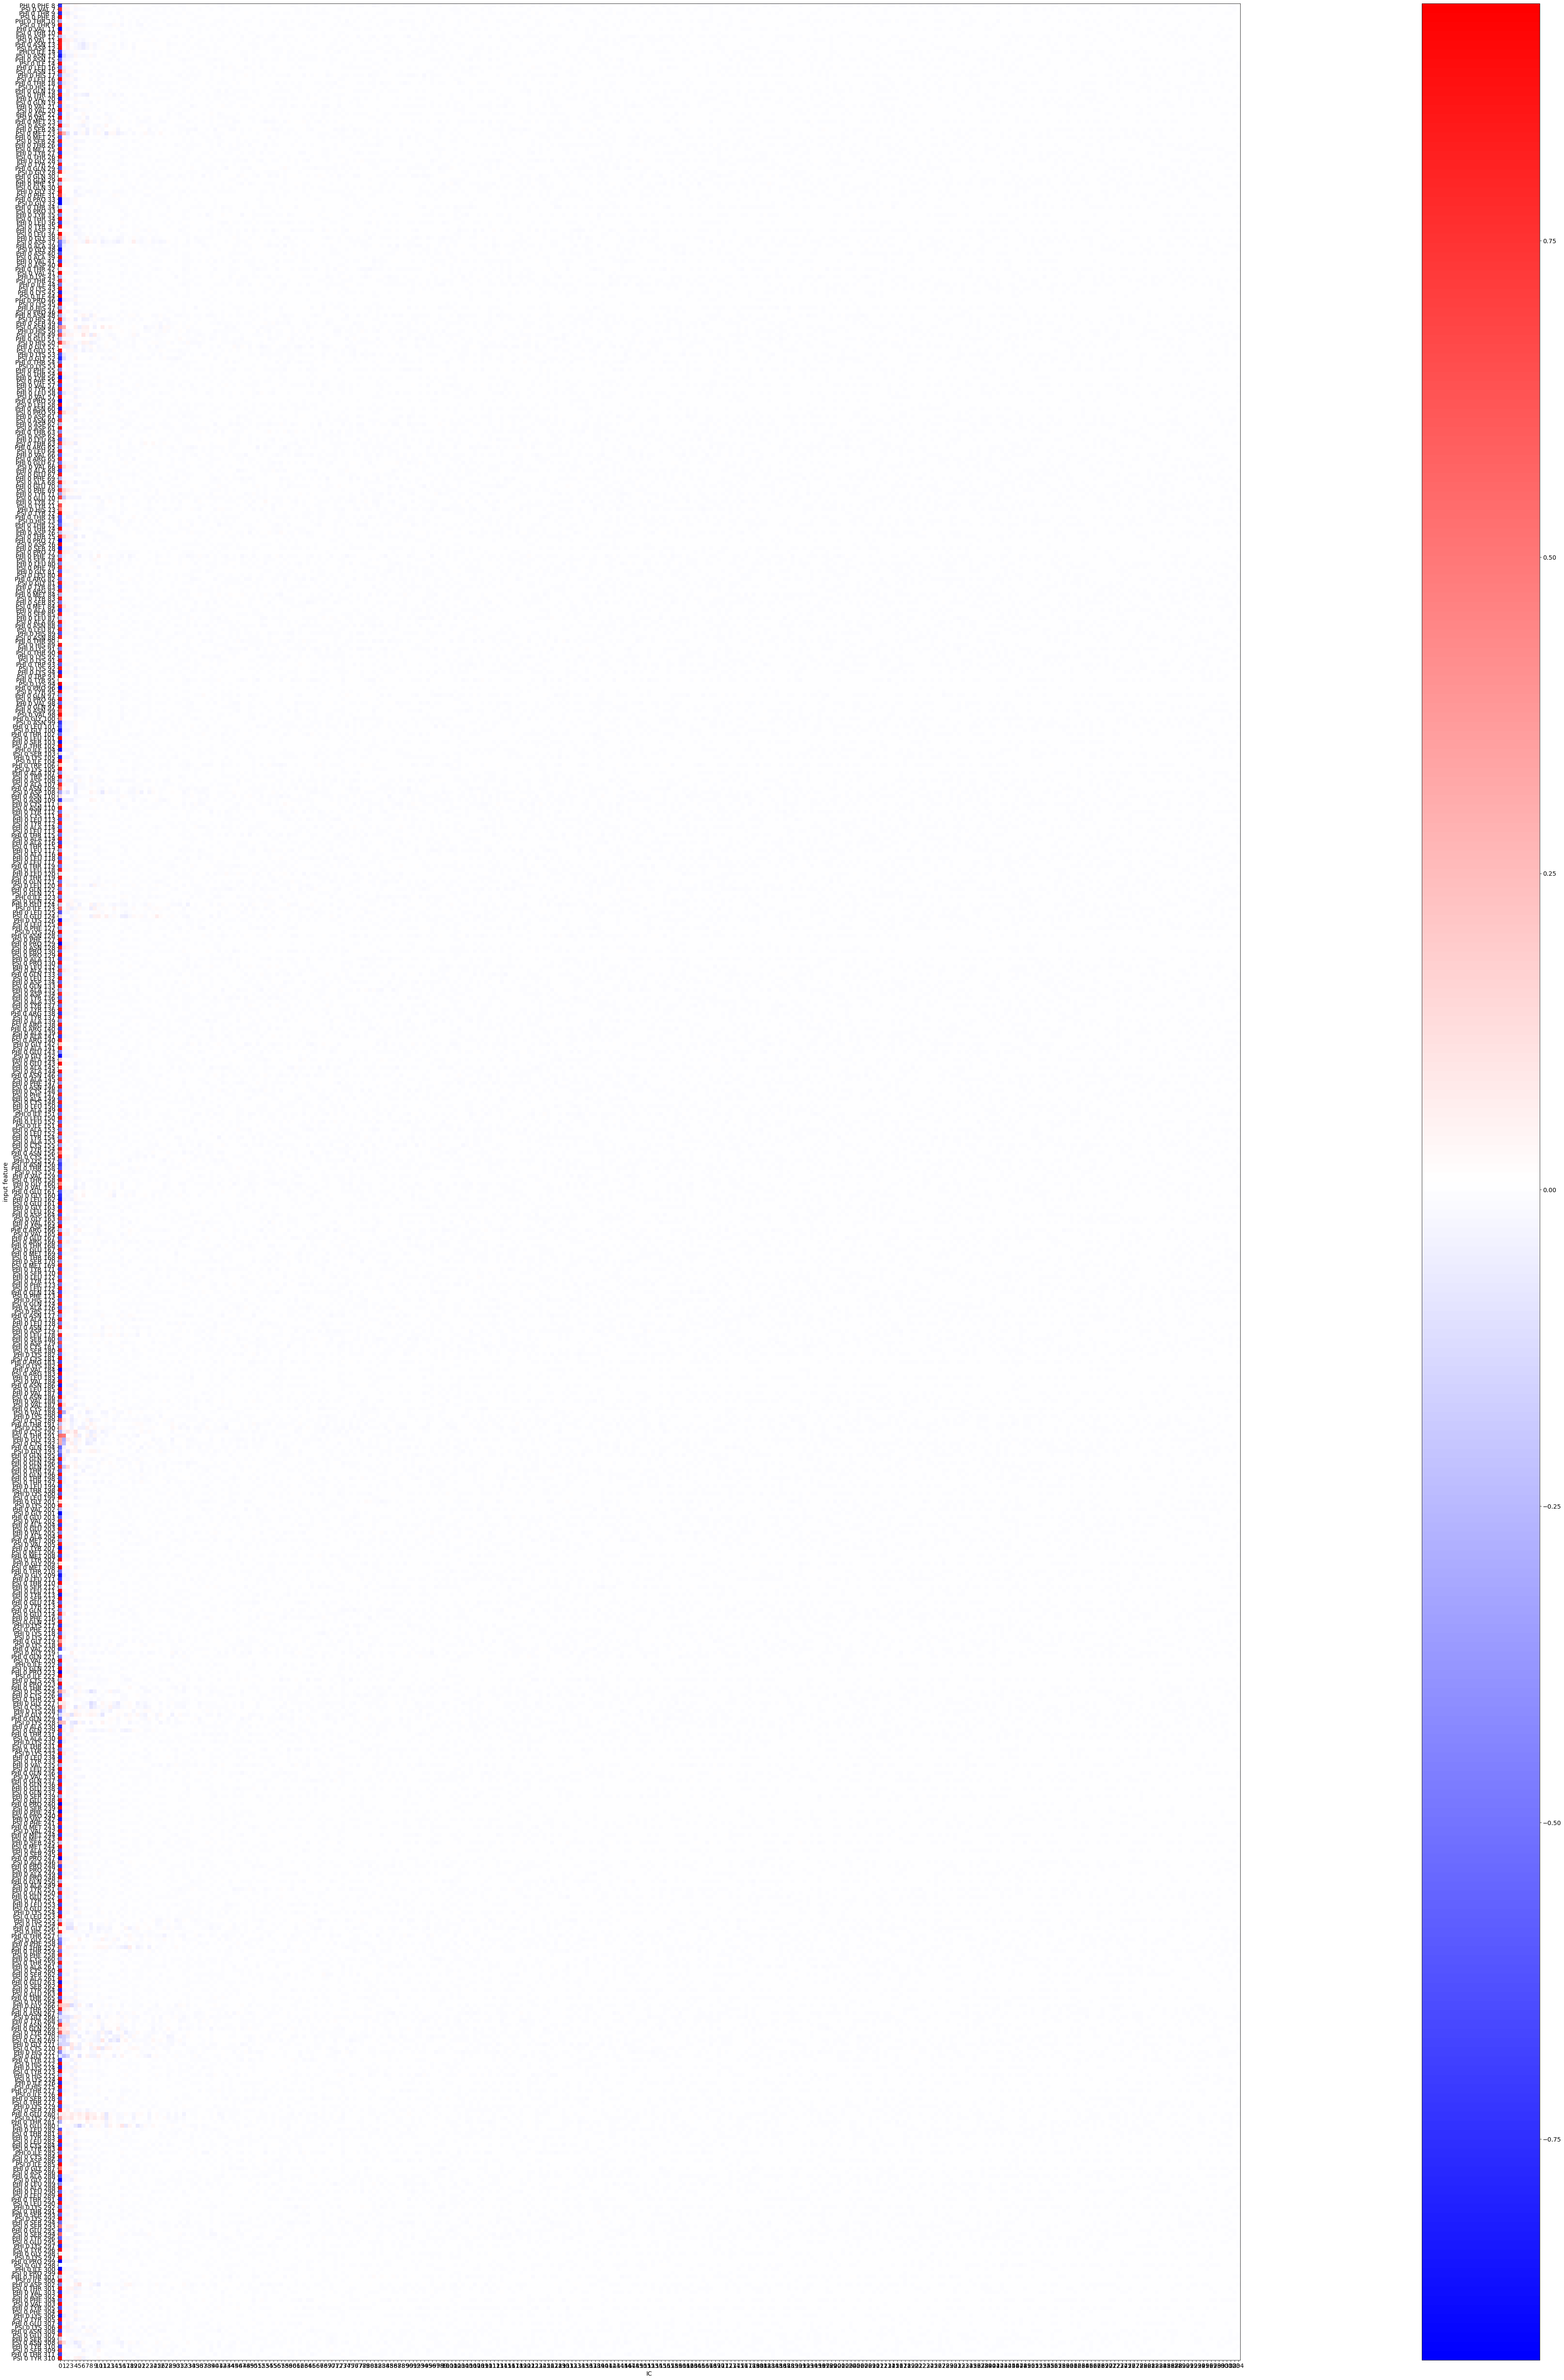

In [34]:
fig, ax = plt.subplots(figsize=(150, 100))
i = ax.imshow(tica.feature_TIC_correlation, cmap='bwr')

ax.set_xticks(range(tica.dimension()))
ax.set_xlabel('IC')

ax.set_yticks(range(feat.dimension()))
ax.set_yticklabels(feat.describe())
ax.set_ylabel('input feature')

fig.colorbar(i);

calculate covariances:   0%|          | 0/4 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/4 [00:00<?, ?it/s]

/home/gmf/conda/envs/pyemma/lib/python3.9/site-packages/pyemma/plots/plots2d.py:251: UserWarning: ignore_dim_warning=True is not an allowed optional parameter and will be ignored
  _warn(


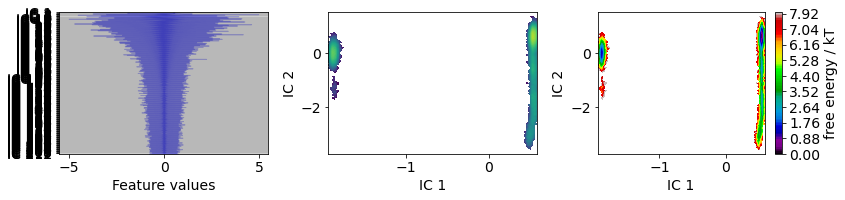

In [35]:
tica = pyemma.coordinates.tica(data)
tica_concatenated = np.concatenate(tica.get_output())

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0], ignore_dim_warning=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True, ignore_dim_warning=True)
pyemma.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False, ignore_dim_warning=True) 
for ax in axes.flat[1:]:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
fig.tight_layout()

In [36]:
#Lag and dim selection

lag=800
tica_obj = coor.tica(data, lag=lag, dim=2, kinetic_map=True)




Y = tica_obj.get_output()
for idx, yy in enumerate(Y):
    print('Projected data shape of data_concatenated %s = %s' % (idx, yy.shape))
    
print(" ")
print (tica_obj.ndim)
print (-lag/np.log(tica_obj.eigenvalues[:10]))

calculate covariances:   0%|          | 0/4 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/4 [00:00<?, ?it/s]

Projected data shape of data_concatenated 0 = (10025, 2)
Projected data shape of data_concatenated 1 = (10025, 2)
Projected data shape of data_concatenated 2 = (10025, 2)
Projected data shape of data_concatenated 3 = (60054, 2)
 
2
[19915.78225379  3262.89563317  1305.96967747  1215.07643975
  1132.32049349  1088.1525252    920.54856898            nan
   761.52719519   723.58634497]


<ipython-input-36-c7132d88f0b1>:15: RuntimeWarning: invalid value encountered in log
  print (-lag/np.log(tica_obj.eigenvalues[:10]))


In [37]:
#Assign your systems here. In my example the first 10 trajectories are the WT-system trajectories and 
#the rest MUT-systems. Change according to your systems

ALL = np.concatenate(Y[:])
SR_SRC = np.concatenate(Y[0:5])
# SR_Ant = np.concatenate(Y[5:])

print(ALL.shape)
print(SR_SRC.shape)
# print(SR_Ant.shape)


(90129, 2)
(90129, 2)


<ipython-input-38-f81bef8a2f7c>:3: RuntimeWarning: divide by zero encountered in log
  F_ALL = -np.log(z)


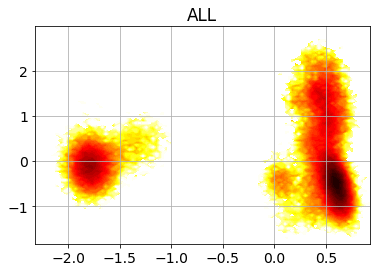

In [38]:
# LOOK VALUE RANGE for the TICA plot, and update to the following cell
z,x,y = np.histogram2d(ALL[:,0],ALL[:,1], bins=100)
F_ALL = -np.log(z)
extent_ALL = [x[0], x[-1], y[0], y[-1]]
contourf(F_ALL.T, 50, cmap=plt.cm.hot, extent=extent_ALL);plt.title('ALL');grid() # .T is transpose of the array

Text(0.5, 0, 'time (ns)')

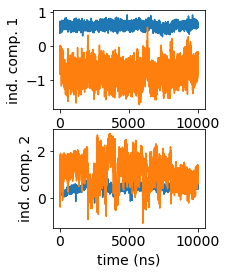

In [39]:
#plot tica
subplot2grid((2,2),(0,0))
plot(Y[0])
ylabel('ind. comp. 1')
subplot2grid((2,2),(1,0))
plot(Y[2])
ylabel('ind. comp. 2')
xlabel('time (ns)')



In [40]:
print('Mean values: ', np.mean(Y, axis=0))
print('Variances:   ', np.var(Y, axis=0))

/home/gmf/conda/envs/pyemma/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: operands could not be broadcast together with shapes (10025,2) (60054,2) 

<ipython-input-41-35af9d6d9b9c>:4: RuntimeWarning: divide by zero encountered in log
  F = -np.log(z)


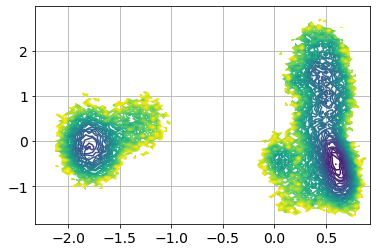

In [41]:
#histogram data
# z,x,y = np.histogram2d(Y[0], Y[1], Y[2],  bins=50)
#Compute free energies
F = -np.log(z)
#contour plot
extent = [x[0], x[-1], y[0], y[-1]]
contour(F.T, 50, cmap=plt.cm.viridis, extent=extent);grid()

In [42]:
Y[0]

array([[ 0.47070324, -0.510392  ],
       [ 0.46159735, -0.6102684 ],
       [ 0.4593218 , -0.516874  ],
       ...,
       [ 0.6091926 , -0.616698  ],
       [ 0.6124563 , -0.6397428 ],
       [ 0.6186065 , -0.62266827]], dtype=float32)

In [43]:
#Clustering
cl = coor.cluster_kmeans(data=Y, stride=1, max_iter=100)#,k=100)#,k=200) # using min(sqrt(N), 5000)=293 as n_clusters.
#save discrete trajs and cluster center coordinates for later use
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]

22-04-22 08:24:28 pyemma.coordinates.clustering.kmeans.KmeansClustering[112] INFO     The number of cluster centers was not specified, using min(sqrt(N), 5000)=300 as n_clusters.


initialize kmeans++ centers:   0%|          | 0/300 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/100 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|          | 0/4 [00:00<?, ?it/s]

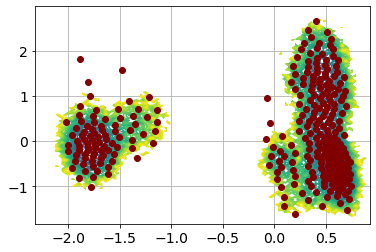

In [44]:
#Visualize clusters
contour(F.T, 50, cmap=plt.cm.viridis, extent=extent);grid()
plot(cc_x,cc_y, linewidth=0, marker='o', color='maroon')

In [50]:
#MSM estimation
#show the ITS convergence to help selecting a suitable lag time
lags = [50,100,200,300,400,500,600,700,800]
its = msm.its(dtrajs, lags=lags, errors='bayes')

estimating BayesianMSM:   0%|          | 0/9 [00:00<?, ?it/s]

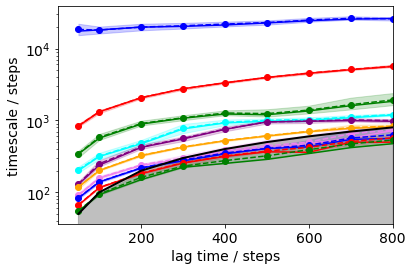

In [51]:
mplt.plot_implied_timescales(its, nits=10)
plt.savefig('lagTime.png')

In [52]:
M = msm.bayesian_markov_model(dtrajs, lag)

pyemma.msm.estimators.bayesian_msm.BayesianMSM[122]: compute stat. inefficiencies:   0%|          | 0/21478 [0…

pyemma.msm.estimators.bayesian_msm.BayesianMSM[122]: Sampling MSMs:   0%|          | 0/100 [00:00<?, ?it/s]

pyemma.msm.estimators.bayesian_msm.BayesianMSM[123]: compute stat. inefficiencies:   0%|          | 0/21478 [0…

pyemma.msm.estimators.bayesian_msm.BayesianMSM[123]: Sampling MSMs:   0%|          | 0/100 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|          | 0/9 [00:00<?, ?it/s]

/home/gmf/conda/envs/pyemma/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 299 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/home/gmf/conda/envs/pyemma/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 298 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)


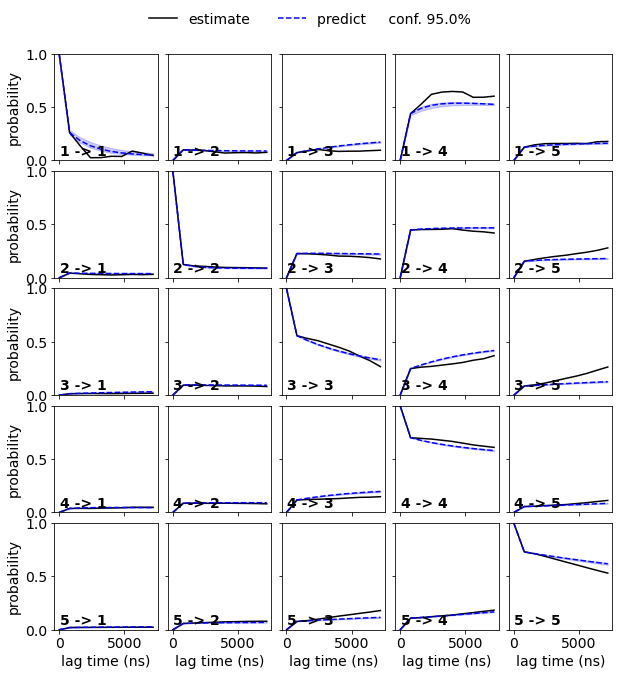

In [53]:
#Chapman-Kolmogorov test
bayesian_msm = pyemma.msm.bayesian_markov_model(cl.dtrajs, lag=lag, dt_traj='1 ns', conf=0.95)
pyemma.plots.plot_cktest(bayesian_msm.cktest(5), units='ns');
plt.savefig('estimate.png')

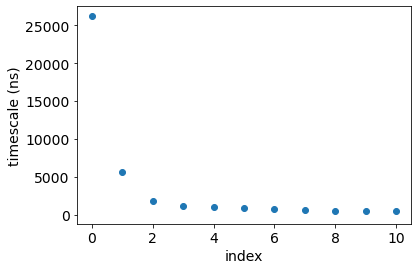

In [54]:
plot(M.timescales(),linewidth=0,marker='o')
xlabel('index'); ylabel('timescale (ns)'); xlim(-0.5,10.5)
plt.savefig('timeScale.png')

In [55]:
nstates = 5
M.pcca(nstates)

PCCA(P=array([[7.98722e-03, 0.00000e+00, ..., 8.39624e-04, 0.00000e+00],
       [0.00000e+00, 3.15985e-02, ..., 0.00000e+00, 0.00000e+00],
       ...,
       [2.07544e-03, 0.00000e+00, ..., 2.21239e-02, 0.00000e+00],
       [0.00000e+00, 0.00000e+00, ..., 0.00000e+00, 6.66134e-16]]),
   m=5)

<ipython-input-56-343f91d92411>:3: RuntimeWarning: divide by zero encountered in log
  F_dtrajs = -np.log(z)


Text(0.5, 1.0, '5th metastable state')

<Figure size 432x288 with 0 Axes>

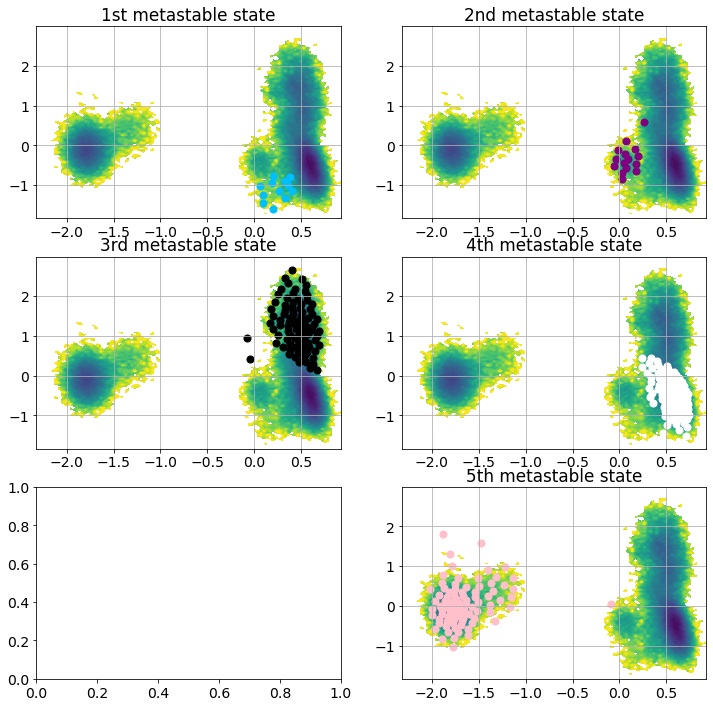

In [56]:
#Here is just template for PCCA states
M.pcca(5)
F_dtrajs = -np.log(z)
extent_dtrajs = [x[0], x[-1], y[0], y[-1]]
#
figure()
pcca_dist = M.metastable_distributions
ax = plt.subplots(2, 2, figsize=(12,12))
pcca_sets = M.metastable_sets

subplot2grid((3,2),(0,0))
ax=contourf(F_dtrajs.T, 50, cmap=plt.cm.viridis, extent=extent_dtrajs)
ax=scatter(cl.clustercenters[pcca_sets[0],0], cl.clustercenters[pcca_sets[0],1], color='deepskyblue', s=50);grid()
plt.title('1st metastable state')

subplot2grid((3,2),(0,1))
ax=contourf(F_dtrajs.T, 50, cmap=plt.cm.viridis, extent=extent_dtrajs)
ax=scatter(cl.clustercenters[pcca_sets[1],0], cl.clustercenters[pcca_sets[1],1], color='purple', s=50);grid()
plt.title('2nd metastable state')

subplot2grid((3,2),(1,0))
ax=contourf(F_dtrajs.T, 50, cmap=plt.cm.viridis, extent=extent_dtrajs)
ax=scatter(cl.clustercenters[pcca_sets[2],0], cl.clustercenters[pcca_sets[2],1], color='black', s=50);grid()
plt.title('3rd metastable state')

subplot2grid((3,2),(1,1))
ax=contourf(F_dtrajs.T, 50, cmap=plt.cm.viridis, extent=extent_dtrajs)
ax=scatter(cl.clustercenters[pcca_sets[3],0], cl.clustercenters[pcca_sets[3],1], color='white', s=50);grid()
plt.title('4th metastable state')
subplot2grid((3,2),(2,0))

subplot2grid((3,2),(2,1))
ax=contourf(F_dtrajs.T, 50, cmap=plt.cm.viridis, extent=extent_dtrajs)
ax=scatter(cl.clustercenters[pcca_sets[4],0], cl.clustercenters[pcca_sets[4],1], color='pink', s=50);grid()
plt.title('5th metastable state')

# plt.savefig('PLPprometas.eps')

<ipython-input-57-9a5eafa2e01d>:3: RuntimeWarning: divide by zero encountered in log
  F_dtrajs = -np.log(z)


<Figure size 432x288 with 0 Axes>

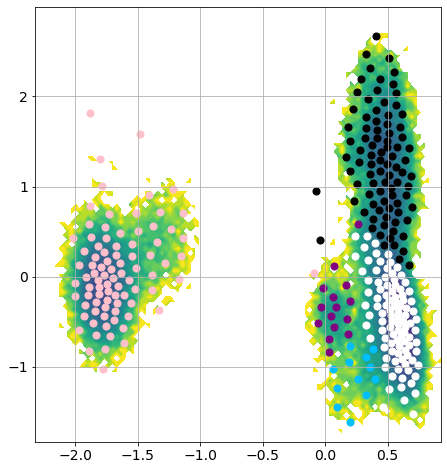

In [57]:
#Here is just template for PCCA states
M.pcca(5)
F_dtrajs = -np.log(z)
extent_dtrajs = [x[0], x[-1], y[0], y[-1]]
tica = pyemma.coordinates.tica(data_concatenated, lag=lag)
tica_concatenated = np.concatenate(tica.get_output())

#
figure()
pcca_dist = M.metastable_distributions
ax = plt.subplots(1, 1, figsize=(16,8))
pcca_sets = M.metastable_sets

subplot2grid((1,2),(0,0))
ax=contourf(F_dtrajs.T, 50, cmap=plt.cm.viridis, extent=extent_dtrajs)
ax=scatter(cl.clustercenters[pcca_sets[0],0], cl.clustercenters[pcca_sets[0],1], color='deepskyblue', s=50);grid()
ax=scatter(cl.clustercenters[pcca_sets[1],0], cl.clustercenters[pcca_sets[1],1], color='purple', s=50);grid()
ax=scatter(cl.clustercenters[pcca_sets[2],0], cl.clustercenters[pcca_sets[2],1], color='black', s=50);grid()
ax=scatter(cl.clustercenters[pcca_sets[3],0], cl.clustercenters[pcca_sets[3],1], color='white', s=50);grid()
ax=scatter(cl.clustercenters[pcca_sets[4],0], cl.clustercenters[pcca_sets[4],1], color='pink', s=50);grid()

# ax=pyemma.plots.plot_free_energy(tica_concatenated[:,0].T, tica_concatenated[:,1].T)
plt.savefig('PLPprometas.eps')

<Figure size 864x864 with 0 Axes>

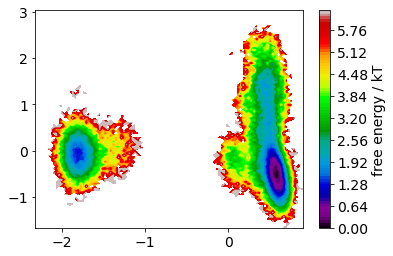

In [58]:
plt.figure(figsize=(12,12))
ax=pyemma.plots.plot_free_energy(tica_concatenated[:,0].T, tica_concatenated[:,1].T)

plt.savefig('PLPprofreeE.eps')

π_1 = 0.027622
π_2 = 0.019702
π_3 = 0.223286
π_4 = 0.529819
π_5 = 0.199571


<ipython-input-59-acd7f25104ee>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  M.metastable_distributions[i][dtrajs],


IndexError: too many indices for array: array is 1-dimensional, but 4 were indexed

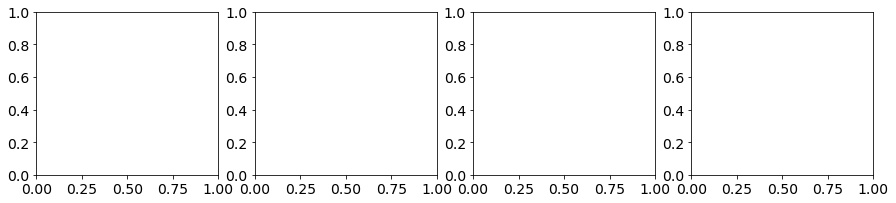

In [59]:
nstates = 5
M.pcca(nstates)

for i, s in enumerate(M.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, M.pi[s].sum()))

fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated.T,
        M.metastable_distributions[i][dtrajs],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

In [61]:
# Saving structures for metastable states,
 
structures_per_metastable_state=10
pcca_dist = M.metastable_distributions
pcca_samples = M.sample_by_distributions(pcca_dist, structures_per_metastable_state)

outfiles = [
       'n5states_state01.pdb',
       'n5states_state02.pdb',
       'n5states_state03.pdb',
       'n5states_state04.pdb',
       'n5states_state05.pdb'
    
]


# # structures_per_metastable_state=20
# # pcca_dist_ALL = ALL.metastable_distributions
# # pcca_samples = ALL.sample_by_distributions(pcca_dist_ALL, structures_per_metastable_state)
# #
# #outfiles = [
# #    'PCCA-structures/yhd-GDP-GTP_5states_1.xtc',
# #]
# #
# ## There is a bug in the package, multiple trajectories can not be outputted automatically,
# ## we need to combine trajetory with gromacs tools etc. I did it alreay
# trajfile = 'All_plpPro.xtc'

trajfile =(['915_rep1.xtc'] + ['916_rep1.xtc'] + ['917_rep1.xtc'] + ['all_ba4.xtc.xtc'])
fake_input = coor.source(trajfile, feat)
# ## And then we can save coordinates
pyemma.coordinates.save_trajs(fake_input, pcca_samples, fmt=None,
              inmemory=False, stride=1, verbose=False, outfiles=outfiles)

# coor.save_trajs(fake_input, pcca_samples,outfiles=outfiles)

Obtaining file info:   0%|          | 0/4 [00:00<?, ?it/s]

['n5states_state01.pdb',
 'n5states_state02.pdb',
 'n5states_state03.pdb',
 'n5states_state04.pdb',
 'n5states_state05.pdb']

In [62]:
###END OF MSM - FLUX

# some helper functions
def average_by_state(dtraj, x, nstates):
    assert(len(dtraj) == len(x))
    N = len(dtraj)
    res = np.zeros((nstates))
    for i in range(nstates):
        I = np.argwhere(dtraj == i)[:,0]
        res[i] = np.mean(x[I])
    return res

def avg_by_set(x, sets):
    # compute mean positions of sets. This is important because of some technical points the set order
    # in the coarse-grained TPT object can be different from the input order.
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg

In [63]:
xavg = avg_by_set(cc_x, pcca_sets)
A = pcca_sets[xavg.argmax()]
B = pcca_sets[xavg.argmin()]

print(xavg)

[ 0.24137582  0.08445783  0.44841349  0.54198909 -1.65402234]


In [64]:
fluxAB = msm.tpt(M, A, B)

In [65]:
# mean first passage times in microseconds
print(0.01*M.mfpt(A, B))
print(0.01*M.mfpt(B, A))

1167.4978261389201
388.83436835188274


<Figure size 576x360 with 0 Axes>

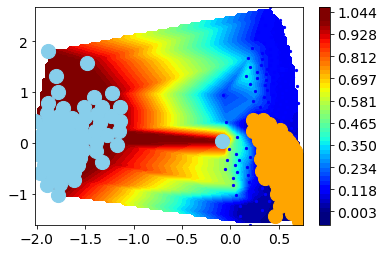

In [66]:
figure(figsize=(8,5))
mplt.scatter_contour(cl.clustercenters[:,0], cl.clustercenters[:,1], fluxAB.committor, colorbar=True, ncontours=15)
scatter(cl.clustercenters[A,0], cl.clustercenters[A,1], color='orange', s=200)
scatter(cl.clustercenters[B,0], cl.clustercenters[B,1], color='skyblue', s=200)

In [67]:
cg, cgflux = fluxAB.coarse_grain(pcca_sets)

In [68]:
# compute mean positions of sets. This is important because of some technical points the set order
# in the coarse-grained TPT object can be different from the input order.
avgpos = np.zeros((5,2))
avgpos[:,0] = avg_by_set(cc_x, cg)
avgpos[:,1] = avg_by_set(cc_y, cg)

<ipython-input-75-fb8547b885d4>:3: UserWarning: The following kwargs were not used by contour: 'fig'
  cf=contourf(F.T, 30, cmap=plt.cm.viridis, extent=extent, fig=f_size,zorder=0)


<Figure size 1080x720 with 0 Axes>

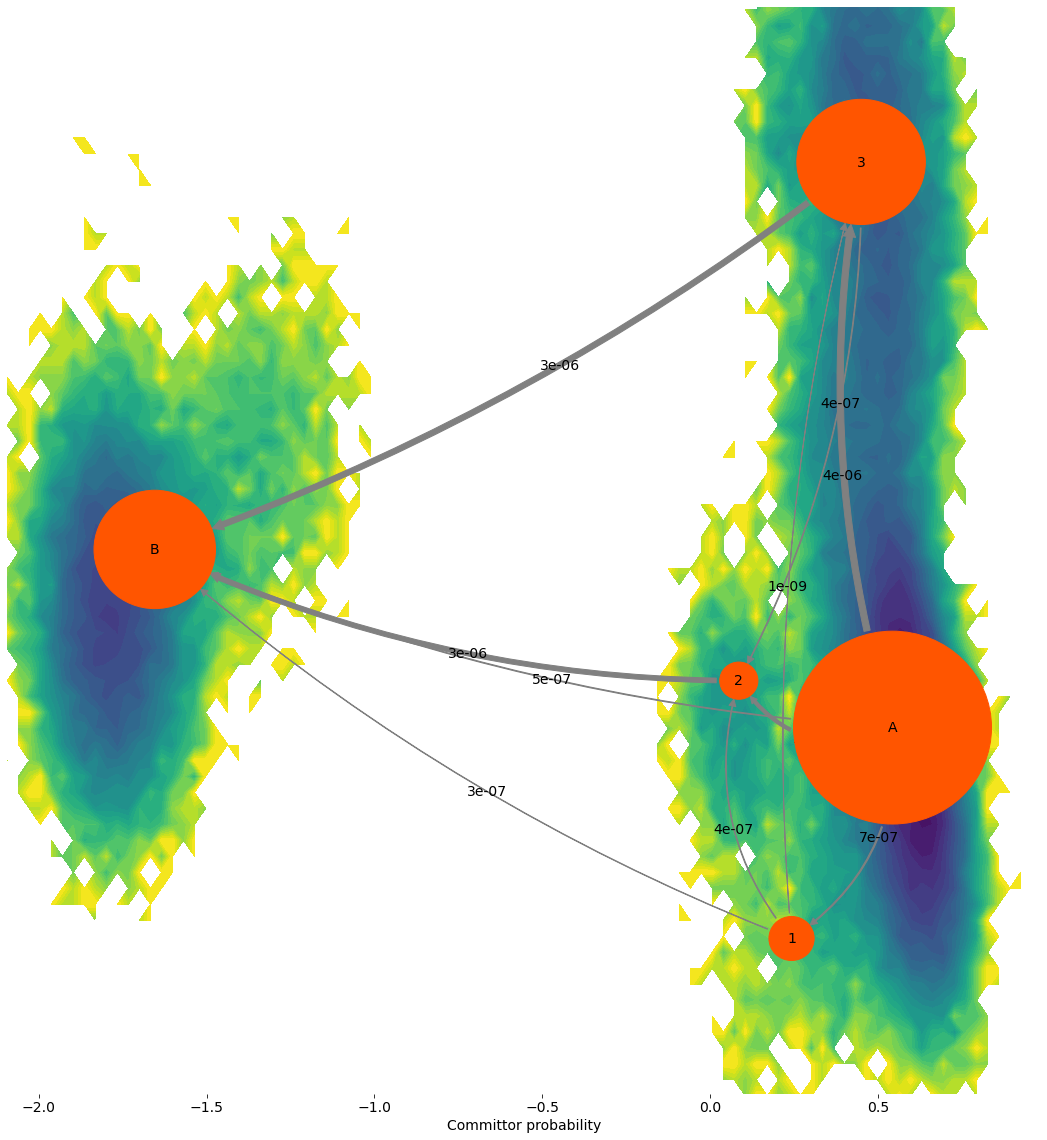

In [75]:
f_size = figure(figsize=(15,10))
_ = mplt.plot_flux(cgflux, avgpos, cgflux.stationary_distribution,max_width=30,max_height=20)
cf=contourf(F.T, 30, cmap=plt.cm.viridis, extent=extent, fig=f_size,zorder=0)
#plt.xlim([-1.5, 2.5])
# plt.ylim([-4, 2.5])

plt.savefig('PLPpro-CP.eps')